In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

First 5 rows after cleaning:


,Date,High
0,2019-01-01,3850.913765
1,2019-01-02,3947.981273
2,2019-01-03,3935.685131
3,2019-01-04,3865.934532
4,2019-01-05,3904.903096


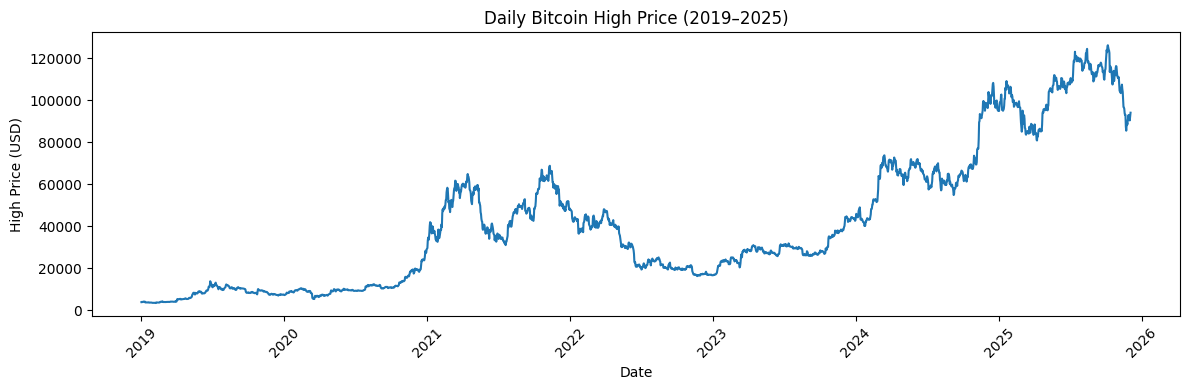

Train range: 2019-01-01 → 2022-12-31, days = 1461
Test  range: 2023-01-01 → 2025-12-03, days = 1068

Shapes:
X_train: (1431, 30, 1)
y_train: (1431, 1)
X_test:  (1038, 30, 1)
y_test:  (1038, 1)


In [10]:
# ---------------------------------------------------------
# Config
# ---------------------------------------------------------
CSV_PATH = "bitcoin_prices.csv"
WINDOW_SIZE = 30

# ---------------------------------------------------------
# 1. Load CSV and keep Date + High
# ---------------------------------------------------------
df = pd.read_csv(CSV_PATH, sep=";")

# Convert timeOpen to a date (drop time component)
df["Date"] = pd.to_datetime(df["timeOpen"]).dt.date

# Keep only Date and daily high price
df = df[["Date", "high"]].rename(columns={"high": "High"})

# Ensure chronological order (your sample is reverse-chronological)
df = df.sort_values("Date").reset_index(drop=True)

print("First 5 rows after cleaning:")
display(df.head())

# ---------------------------------------------------------
# 2. Visualize the series
# ---------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["High"])
plt.title("Daily Bitcoin High Price (2019–2025)")
plt.xlabel("Date")
plt.ylabel("High Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3. Train / Test split (by date)
#    Train: 2019–2022
#    Test:  2023–2025
# ---------------------------------------------------------
split_date = pd.to_datetime("2023-01-01").date()

train_df = df[df["Date"] < split_date].copy()   # 2019–2022
test_df  = df[df["Date"] >= split_date].copy()  # 2023–2025

print(f"Train range: {train_df['Date'].min()} → {train_df['Date'].max()}, days = {len(train_df)}")
print(f"Test  range: {test_df['Date'].min()} → {test_df['Date'].max()}, days = {len(test_df)}")

# ---------------------------------------------------------
# 4. Scale the data (fit on train, apply to both)
# ---------------------------------------------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[["High"]])
test_scaled = scaler.transform(test_df[["High"]])

# ---------------------------------------------------------
# 5. Create sliding windows (30-day lookback → next-day prediction)
# ---------------------------------------------------------
def create_sliding_windows(series: np.ndarray, window_size: int = 30):
    """
    series: shape (N, 1) or (N,)
    Returns:
        X: (num_samples, window_size, 1)
        y: (num_samples, 1)
    """
    if series.ndim == 1:
        series = series.reshape(-1, 1)

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])  # past 30 days
        y.append(series[i + window_size])    # next day

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE)
X_test, y_test   = create_sliding_windows(test_scaled, WINDOW_SIZE)

print("\nShapes:")
print("X_train:", X_train.shape)  # (num_train_samples, 30, 1)
print("y_train:", y_train.shape)  # (num_train_samples, 1)
print("X_test: ", X_test.shape)   # (num_test_samples, 30, 1)
print("y_test: ", y_test.shape)

# Now you have:
# - df: full Date + High
# - train_df, test_df
# - scaler
# - X_train, y_train, X_test, y_test ready for a Keras model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0147 - mae: 0.0755 - val_loss: 0.0127 - val_mae: 0.0777
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0397 - val_loss: 0.0197 - val_mae: 0.1006
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0396 - val_loss: 0.0102 - val_mae: 0.0701
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0394 - val_loss: 0.0135 - val_mae: 0.0816
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0348 - val_loss: 0.0177 - val_mae: 0.0973
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0356 - val_loss: 0.0106 - val_mae: 0.0723
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0347 - val_loss: 0.0114 - val_mae: 0.0765
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0330 - val_loss: 0.0104 - val_mae: 0.0737
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae

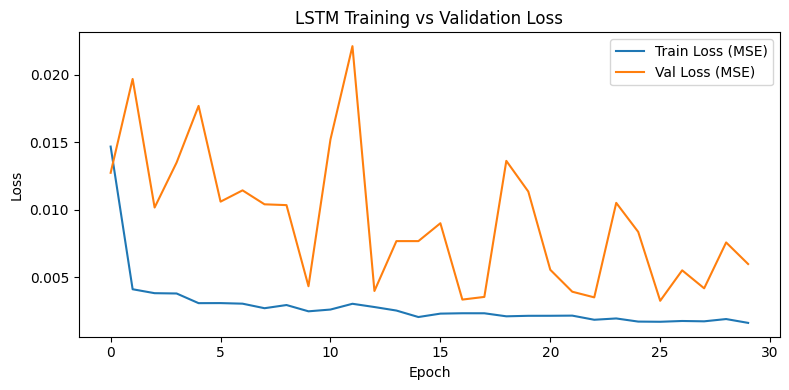

In [11]:
# ---------------------------------------------------------
# 1. Define LSTM model
# ---------------------------------------------------------
model = keras.Sequential([
    layers.Input(shape=(WINDOW_SIZE, 1)),
    
    # First LSTM layer
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    
    # Second LSTM layer (you can remove this if you want a simpler model)
    layers.LSTM(32),
    layers.Dropout(0.2),
    
    # Dense output layer for regression (predict next day's scaled price)
    layers.Dense(1)
])

model.summary()

# ---------------------------------------------------------
# 2. Compile the model (Adam + MSE loss, track MAE)
# ---------------------------------------------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",          # mean squared error
    metrics=["mae"]      # mean absolute error (optional but nice to see)
)

# ---------------------------------------------------------
# 3. Train the model
# ---------------------------------------------------------
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------------------------------------
# 4. Plot training & validation loss over epochs
# ---------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Date,Actual_High,Predicted_High
0,2023-01-31,23225.021404,23562.068359
1,2023-02-01,23764.539294,23557.355469
2,2023-02-02,24167.210232,23583.587891
3,2023-02-03,23678.102576,23683.789062
4,2023-02-04,23556.948805,23744.250000


Test RMSE (in original price units): 5,059.15
Normalized RMSE: 7.52% of mean price


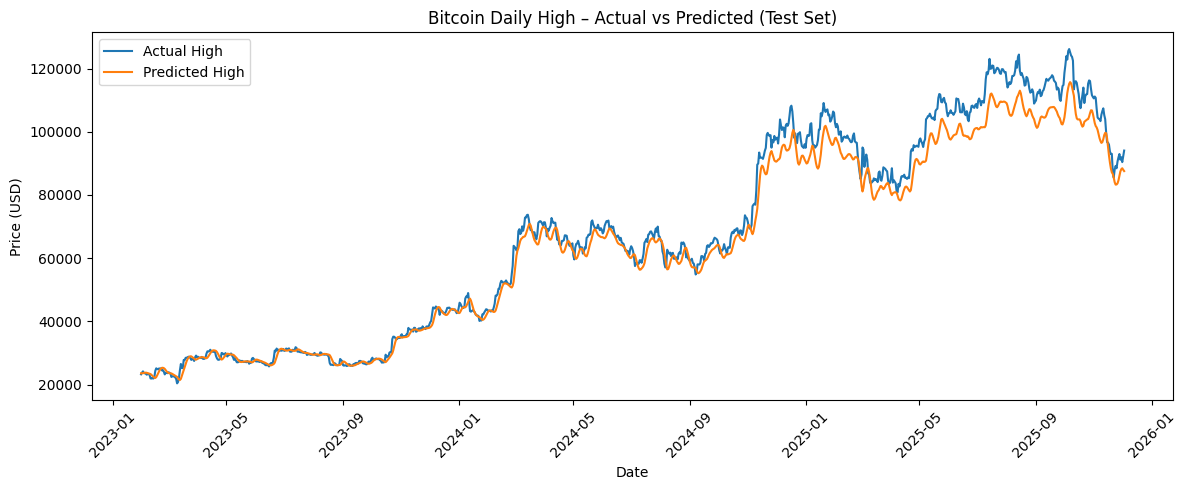

Final Train Loss (MSE): 0.001630
Final Val   Loss (MSE): 0.005991
Heuristic: Validation loss is much higher than training loss → likely overfitting.


In [12]:
# ---------------------------------------------------------
# 1. Predict on test set (scaled)
# ---------------------------------------------------------
y_pred_test = model.predict(X_test)

# ---------------------------------------------------------
# 2. Inverse-transform to original price space
# ---------------------------------------------------------
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred_test)

# Align dates: each y_test corresponds to the day AFTER the 30-day window
test_dates = test_df["Date"].iloc[WINDOW_SIZE:].reset_index(drop=True)

results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual_High": y_test_unscaled.flatten(),
    "Predicted_High": y_pred_unscaled.flatten()
})

display(results_df.head())

# ---------------------------------------------------------
# 3. Compute RMSE
# ---------------------------------------------------------
rmse = np.sqrt(mean_squared_error(
    results_df["Actual_High"], 
    results_df["Predicted_High"]
))

print(f"Test RMSE (in original price units): {rmse:,.2f}")

# Optional: normalized RMSE as % of mean price
mean_price = results_df["Actual_High"].mean()
print(f"Normalized RMSE: {rmse / mean_price * 100:.2f}% of mean price")

# ---------------------------------------------------------
# 4. Plot Actual vs Predicted on test period
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(results_df["Date"], results_df["Actual_High"], label="Actual High")
plt.plot(results_df["Date"], results_df["Predicted_High"], label="Predicted High")
plt.title("Bitcoin Daily High – Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. Quick look at train vs val loss for overfitting discussion
# ---------------------------------------------------------
train_loss_final = history.history["loss"][-1]
val_loss_final = history.history["val_loss"][-1]

print(f"Final Train Loss (MSE): {train_loss_final:.6f}")
print(f"Final Val   Loss (MSE): {val_loss_final:.6f}")

if val_loss_final > train_loss_final * 1.3:
    print("Heuristic: Validation loss is much higher than training loss → likely overfitting.")
elif val_loss_final < train_loss_final * 0.7:
    print("Heuristic: Validation loss is much lower than training loss → possible underfitting / noisy metric.")
else:
    print("Heuristic: Train and validation loss are in a similar range → limited signs of strong overfitting.")